# EDA: Bay Area Bike Share

## Introduction

[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

## Data Wrangling

Year 1 and Year 2 data, from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data) page ,comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

We will start by looking at a sample of the trip data: the first month of the bike trip data, from 2013-08-29 to 2013-09-30. 

In [1]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [2]:
# file locations
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

In [3]:
sample_data = pd.read_csv('201309_trip_data.csv')
display(sample_data.head())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

In [4]:
# Display the first few rows of the station data file.
station_info = pd.read_csv('201402_station_data.csv')
display(station_info.head())

# The mapping function to condense the trip data
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [6]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    new_point['duration'] = float(row['Duration'])/60 
                    # reformat datestrings into multiple columns
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.strftime('%a')
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [7]:
# Process the data 
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thu,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thu,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thu,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thu,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thu,San Francisco,San Francisco,Subscriber


All counts are as expected!



## Exploratory Data Analysis

From `babs_visualizations.py` script we have imported the functions `usage_stats()` and `usage_plot()`. 

In [5]:
trip_data = pd.read_csv('201309_trip_summary.csv')
usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

There are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration (the point where 50% of trips are shorter, and 50% are longer). In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type. 

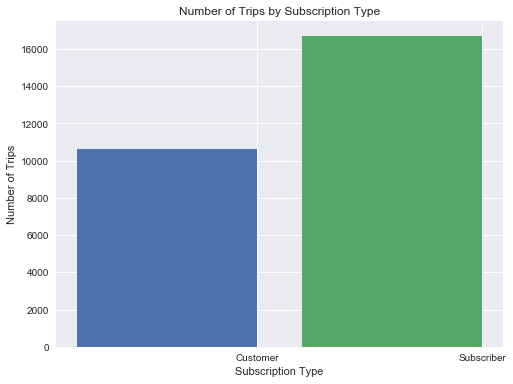

In [6]:
usage_plot(trip_data, 'subscription_type')

It seems there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. 

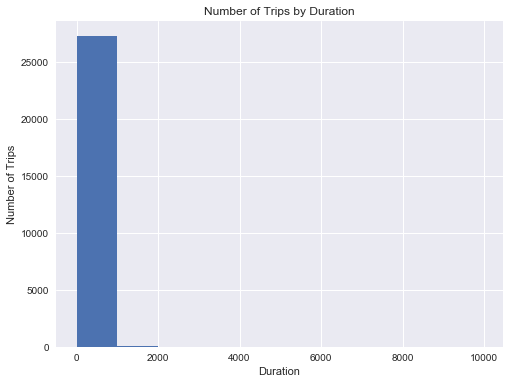

In [7]:
usage_plot(trip_data, 'duration')

Most rides are expected to be 30 minutes or less, since there are overage charges for taking extra time in a single trip. The first bar spans durations up to about 1000 minutes, or over 16 hours. Based on the statistics we got out of `usage_stats()`, we should have expected some trips with very long durations that bring the average to be so much higher than the median. We will subset trips to include those with less than 60 minutes.

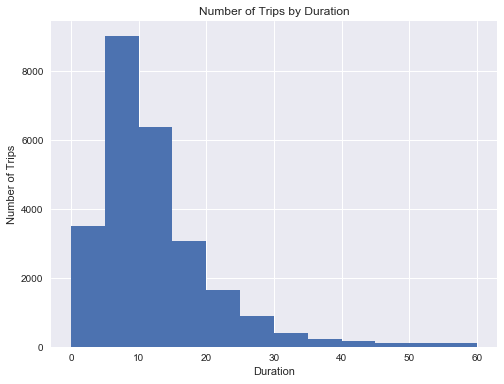

In [12]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

We can see most trips fall into 5-10 min durations, with more than 9000 trips.

## Performing Analysis on Original Data

In [13]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

In [9]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,Thu,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,Thu,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,Thu,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,Thu,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,Thu,San Francisco,San Francisco,Subscriber


In [15]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

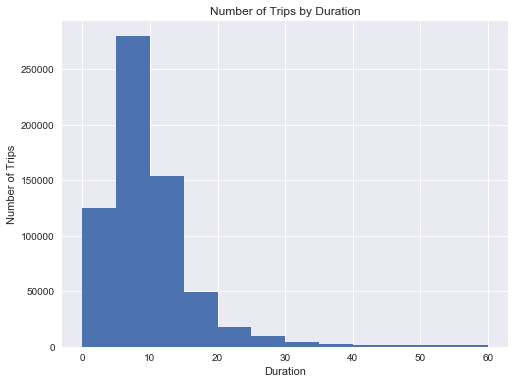

In [16]:
usage_plot(trip_data,'duration', ['duration < 60'], boundary = 0, bin_width = 5)

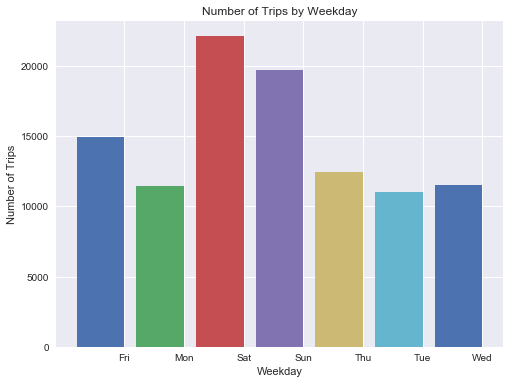

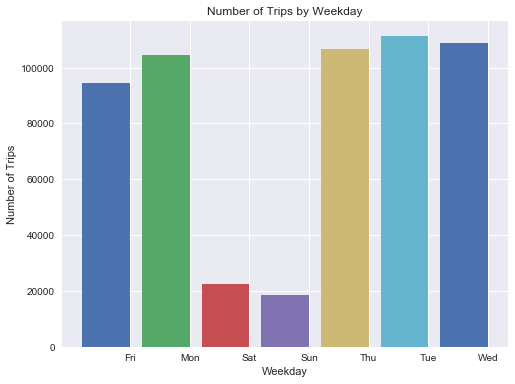

In [10]:
usage_plot(trip_data,'weekday',["subscription_type != 'Subscriber'"])
usage_plot(trip_data,'weekday',["subscription_type == 'Subscriber'"])

The subscribers, mostly as local commuters, use bikes mainly on weekdays while customers, mostly as tourists, ride shared bikes mainly on weekends.

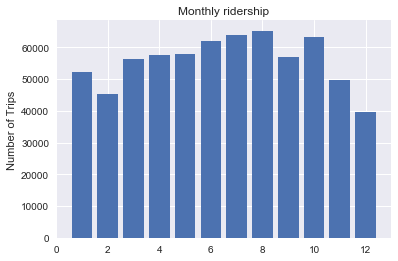

Standardard Deviation is 7504.0


In [32]:
trip_data['count']=1
trip_month=trip_data.groupby(['start_month'])['count'].count()
import matplotlib.pyplot as plt
plt.bar(trip_month.index,trip_month.values)
plt.title('Monthly ridership')
plt.ylabel('Number of Trips')
plt.show()
std=np.std(trip_month)
print("Standardard Deviation is {:}".format(round(std,0)))

Fewest peope use shared bike in Dec. This is probably due to X-mas holiday season. Also, people tend to use bikes more during summer. The warm summer weather may contribute to this trend.